<a target="_blank" href="https://colab.research.google.com/github/cboettig/rl-minicourse/blob/main/challenge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#  RL4Salmon Parameter Tests

In this example, we set up a generic three species, two action problem, and illustrate how to provide a custom population dynamics function, action function, and utility function to represent a caribou conservation objective.  

In [1]:
# we'll need these packages to begin
!pip install stable-baselines3 plotnine polars sb3_contrib tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 20.2 MB/s eta 0:00:00


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # change to -1 if you want to use CPU

In [12]:
import numpy as np
# pop = seals, lamprey, salmon
# Salmon Scenario
def dynamics(pop, effort, population_parameters, harvest_fn, p, timestep=1):

    pop = harvest_fn(pop, effort)
    X, Y, Z = pop[0], pop[1], pop[2]

    K_x = p["K_x"] + population_parameters[0]
    K_y = p["K_y"] + population_parameters[1]
    K_z = p["K_z"]
    D = p["D"]

    X += (p["r_x"] * X * (1 - X / K_x )
            - (1 - D) * p["beta"] * Z * (X**2) / (p["v0"]**2 + X**2)
            + p["sigma_x"] * X * np.random.normal()
            )

    Y += (p["r_y"] * Y * (1 - Y  / K_y )
            - D * p["beta"] * Z * (Y**2) / (p["v0"]**2 + Y**2)
            + p["sigma_y"] * Y * np.random.normal()
            )

    Z += p["alpha"] * p["beta"] * Z * (
            (1-D) * (X**2) / (p["v0"]**2 + X**2)
            + D * (Y**2) / (p["v0"]**2 + Y**2)
            ) - p["dH"] * Z +  p["sigma_z"] * Z  * np.random.normal()

    pop = np.array([X, Y, Z], dtype=np.float32)
    pop = np.clip(pop, [0,0,0], [np.Inf, np.Inf, np.Inf])
    return(pop)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
initial_pop = [0.5, 0.5, 0.2]


parameters = {
"r_x": np.float32(0.13),
"r_y": np.float32(0.2),
"r_z": np.float32(0.05),
"K_x": np.float32(1),
"K_y": np.float32(1),
"K_z": np.float32(1),
"beta": np.float32(.1),
"v0":  np.float32(0.1),
"D": np.float32(0.8),
"tau_yx": 0,
"tau_xy": 0,
"alpha": np.float32(.4),
"dH": np.float32(0.03),
"sigma_x": np.float32(0.05),
"sigma_y": np.float32(0.05),
"sigma_z": np.float32(0.05)
}


We must also define the dynamics of the action, a 'harvest' or culling function.  In this scenario, we imagine that we can cull either the salmon or pinniped population (or both).  We assume our control action introduces a percent mortality equal to the control effort applied times a catachability coefficient:

In [14]:
def harvest(pop, effort):
    q0 = 0.5 # catchability coefficients -- erradication is impossible
    q2 = 0.5
    pop[0] = pop[0] * (1 - effort[0] * q0) # pop 0, seals
    pop[2] = pop[2] * (1 - effort[1] * q2) # pop 2, salmon
    return pop


Lastly, we need to define the utility or reward derived from taking these actions under this population state.  In this scenario, our population control actions are costly, while we acrue a benefit proportional to the size of the current salmon population:

In [15]:
def utility(pop, effort):
    benefits = 0.5 * pop[1] # benefit from Salmon
    costs = .00001 * (effort[0] + effort[1]) # cost to culling
    if np.any(pop <= 0.01):
        benefits -= 1
    return benefits - costs




To simulate our environment and allow RL algorithms to train on this environment, we define a simple python class using the gym module.  This class defines the possible action space as two continuously-valued action variables (culling effort of salmon and pinnipeds respectively), and three continuously valued state variables (population of salmon, lamprey and pinnipeds).  To improve performance of RL training, it is necessary to transform the continuous space to -1, 1

In [17]:
import gymnasium as gym

class s3a2(gym.Env):
    """A 3-species ecosystem model with two control actions"""
    def __init__(self, config=None):
        config = config or {}

        ## these parameters may be specified in config
        self.Tmax = config.get("Tmax", 800)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.dynamics = config.get("dynamics", dynamics)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.observe = config.get("observe", lambda state: state) # default to perfectly observed case
        self.bound = 2 * self.parameters["K_x"]

        self.action_space = gym.spaces.Box(
            np.array([-1, -1, 0, 0], dtype=np.float32),
            np.array([1, 1, 0.1, 0.1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1, -1, -1], dtype=np.float32),
            np.array([1, 1, 1], dtype=np.float32),
            dtype=np.float32,
        )
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.initial_pop += np.multiply(self.initial_pop, np.float32(self.init_sigma * np.random.normal(size=3)))
        self.state = self.state_units(self.initial_pop)
        info = {}
        return self.observe(self.state), info


    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units(self.state) # current state in natural units
        human_actions = action[:2]
        pop_params = action[2:]
        effort = (human_actions + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort, pop_params, self.harvest, self.parameters, self.timestep)

        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)

        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep

        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}

    def state_units(self, pop):
        self.state = 2 * pop / self.bound - 1
        self.state = np.clip(self.state,
                             np.repeat(-1, self.state.__len__()),
                             np.repeat(1, self.state.__len__()))
        return np.float32(self.state)

    def population_units(self, state):
        pop = (state + 1) * self.bound /2
        return np.clip(pop,
                       np.repeat(0, pop.__len__()),
                       np.repeat(np.Inf, pop.__len__()))

# verify that the environment is defined correctly
from stable_baselines3.common.env_checker import check_env
env = s3a2()
check_env(env, warn=True)


Here, we try to achieve quasi-equilibrium between the three species. That is, attempt to make their population proportions at the end of the episode as similar as possible. We obtain the optimal action by minimizing the variance between the three population proportions at the end of the episode.

In [20]:
from scipy.optimize import minimize
import polars as pl
from plotnine import ggplot, aes, geom_line

def get_final_pop(df):
  final_pops = df.select(["X", "Y", "Z"]).tail(1)
  return list(final_pops.to_numpy()[0])

def balance_pops(df):
  final_pops = get_final_pop(df)
  pop_avg = np.mean(final_pops)
  return np.mean((final_pops - pop_avg) ** 2)

def quasi_equilibrium(action):
  df = []
  episode_reward = 0
  observation, _ = env.reset()
  for t in range(env.Tmax):
    obs = env.population_units(observation) # natural units
    df.append([t, episode_reward, *obs])
    observation, reward, terminated, done, info = env.step(action)
    episode_reward += reward

  df = pl.DataFrame(df, schema=["t", "reward", "X", "Y", "Z"])
  return balance_pops(df)

optimal_action = minimize(quasi_equilibrium, [-1,-1,0, 0], method="Nelder-Mead")["x"]

/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


Here, we create a function to run a simulation of an episode by inputting an action, plotting the graph of the population proportions over time, and printing the end population proportions. We test this on the optimal quasi-equilibrium action.

/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
<ipython-input-32-7376641f4bda>:19: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


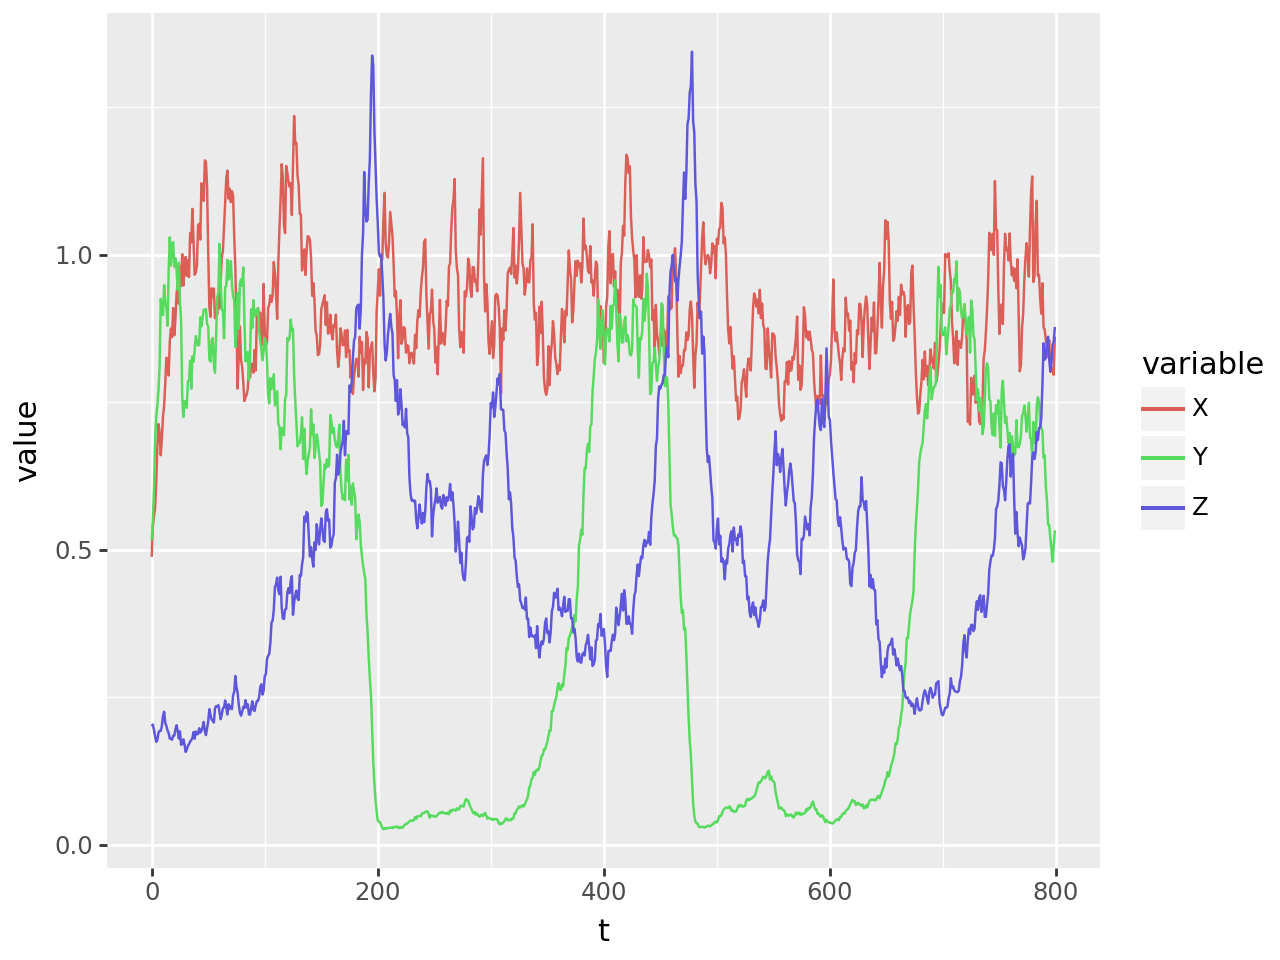

Salmon Population: 0.86
Lamprey Population: 0.53
Pinniped Population: 0.88


In [32]:
def obtain_simulated_data(action):
  df = []
  episode_reward = 0
  observation, _ = env.reset()
  for t in range(env.Tmax):
    obs = env.population_units(observation) # natural units
    df.append([t, episode_reward, *obs])
    observation, reward, terminated, done, info = env.step(action)
    episode_reward += reward

  df = pl.DataFrame(df, schema=["t", "reward", "X", "Y", "Z"])
  return df

def plot_simulation(df):
  cols = ["t", "reward", "X", "Y", "Z"]

  dfl = (pl.DataFrame(df, schema=cols).
          select(["t", "X", "Y", "Z"]).
          melt("t")
        )
  p = ggplot(dfl, aes("t", "value", color="variable")) + geom_line()
  display(p)

def run_simulation(action):
  df = obtain_simulated_data(action)
  plot_simulation(df)
  display_final_pop(get_final_pop(df))

def display_final_pop(pop):
  salmon_str = f"Salmon Population: {pop[0]:.2f}"
  lamprey_str = f"Lamprey Population: {pop[1]:.2f}"
  pinniped_str = f"Pinniped Population: {pop[2]:.2f}"
  print(salmon_str + "\n" + lamprey_str + "\n" + pinniped_str)


run_simulation(optimal_action)

We now run the simulation on a singular action of increasing the carrying capacity of salmon.

/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
<ipython-input-32-7376641f4bda>:19: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


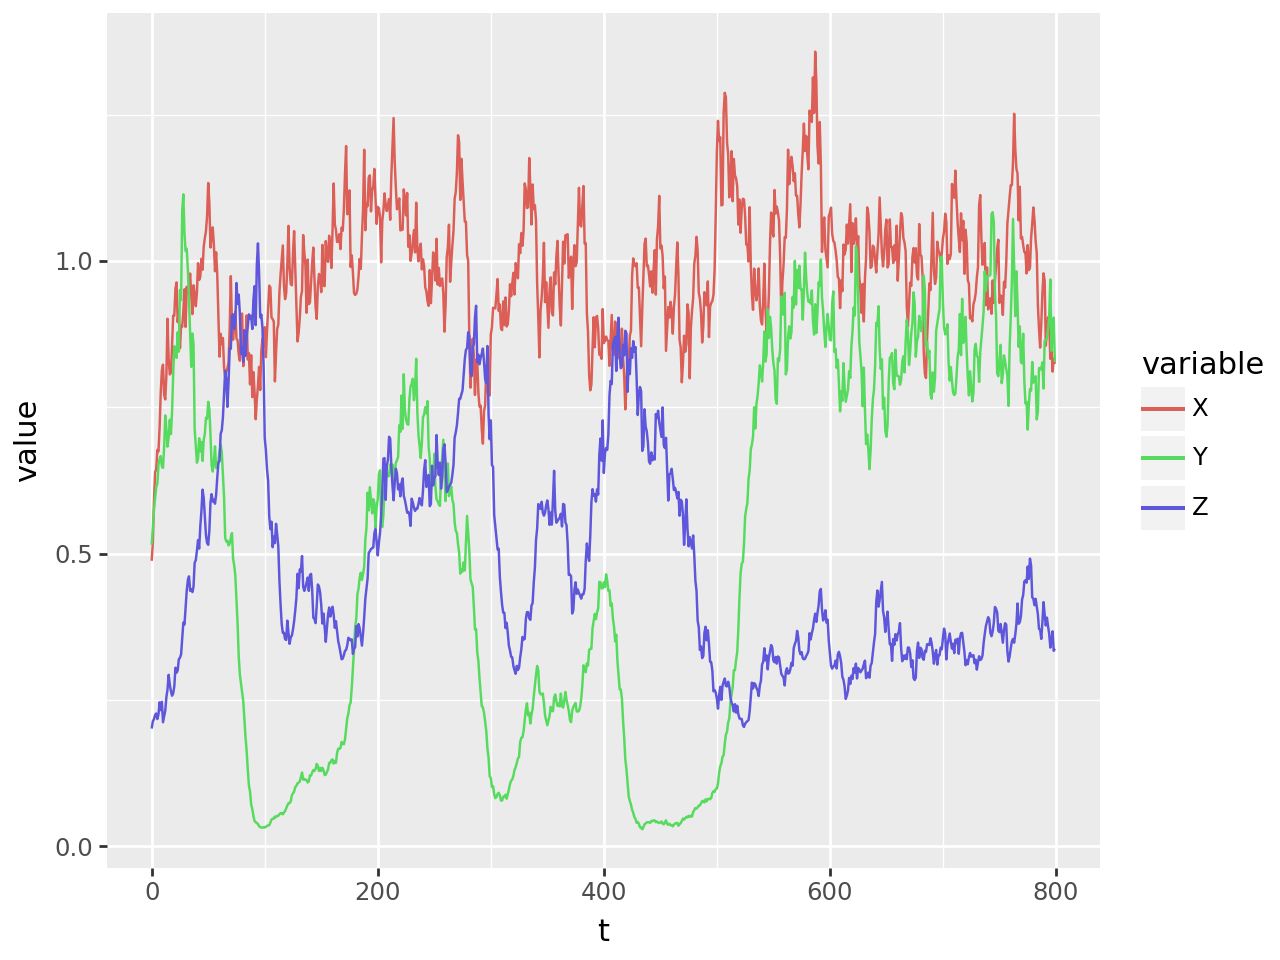

Salmon Population: 0.82
Lamprey Population: 0.83
Pinniped Population: 0.34


In [33]:
run_simulation([-1, -1, 0.1, 0])

We now run a simulation with a singular action that increases the carrying capacity of the lamprey.

/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
<ipython-input-32-7376641f4bda>:19: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


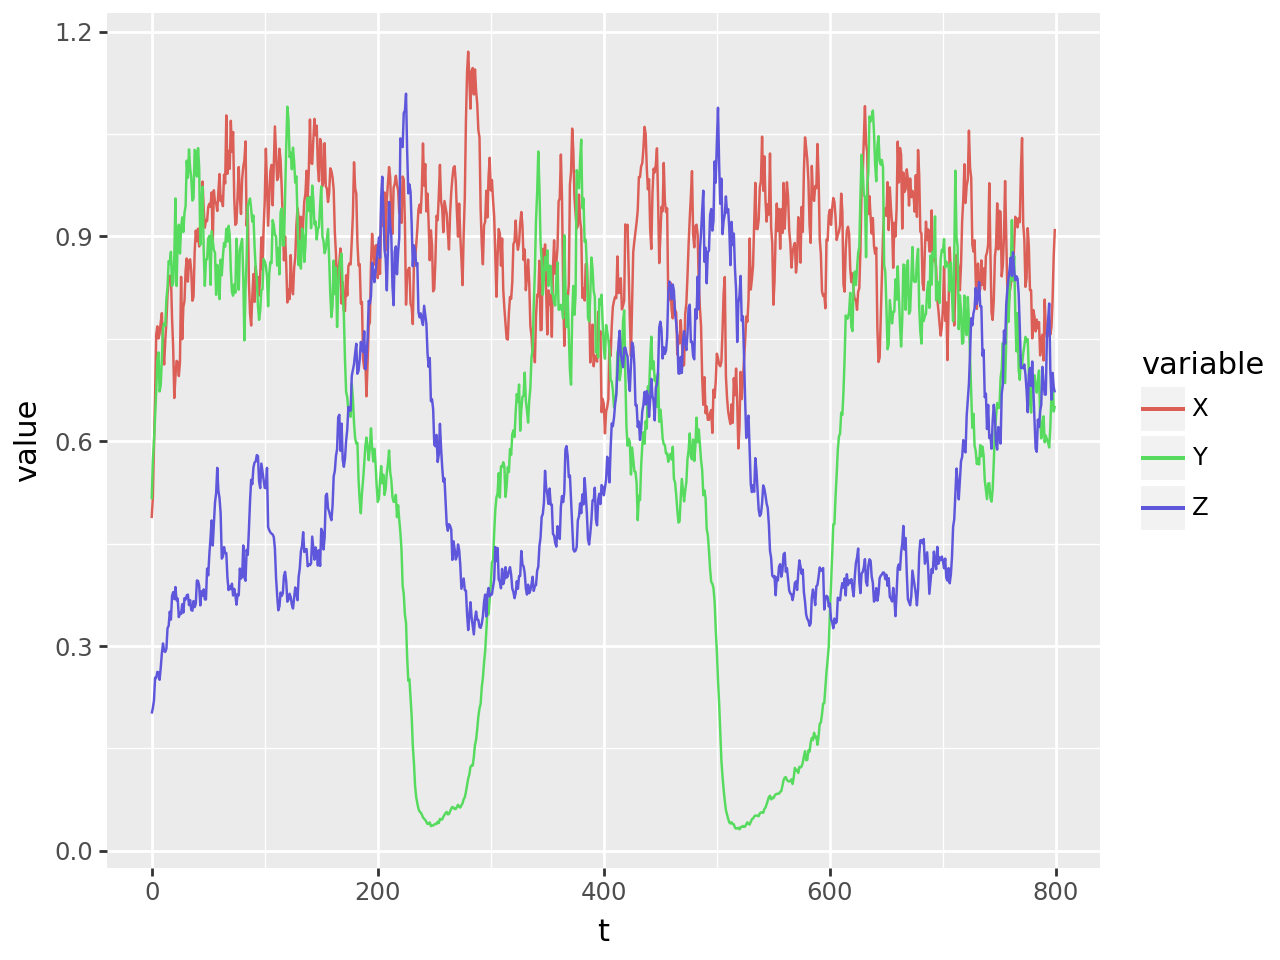

Salmon Population: 0.91
Lamprey Population: 0.65
Pinniped Population: 0.67


In [34]:
run_simulation([-1, -1, 0, 0.1])